#WGAN with LGBM as classifier  with different data sizes

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

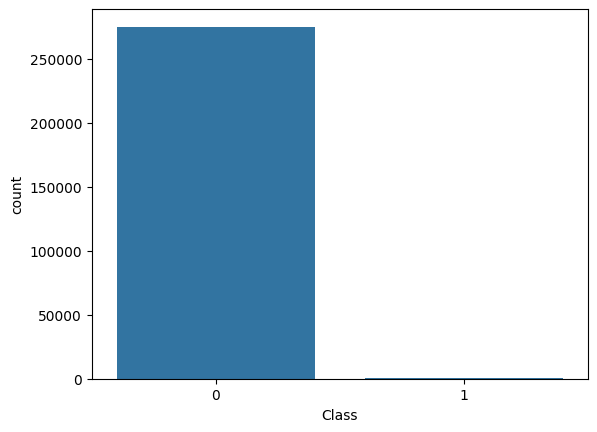

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:

df.dropna(inplace=True)

X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, Flatten, Concatenate, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
import numpy as np

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

class WGAN:
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.n_critic = 5
        self.clip_value = 0.01
        self.batch_size = 64
        self.num_classes = 2

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=wasserstein_loss,
                            optimizer=RMSprop(learning_rate=0.00005))

        # Build the generator
        self.generator = self.build_generator()

        # Combined model
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        fake_sample = self.generator([z, label])
        self.critic.trainable = False
        valid = self.critic([fake_sample, label])

        self.combined = Model([z, label], valid)
        self.combined.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))

    def build_generator(self):
        noise_input = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(1,), dtype='int32')

        # Embedding for labels
        label_embedding = Embedding(self.num_classes, self.latent_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Concatenate noise and label embedding
        model_input = Concatenate()([noise_input, label_embedding])

        model = Dense(128)(model_input)
        model = LeakyReLU(0.2)(model)
        model = Dense(256)(model)
        model = LeakyReLU(0.2)(model)
        model = Dense(512)(model)
        model = LeakyReLU(0.2)(model)
        model = Dense(self.out_shape, activation='tanh')(model)

        return Model([noise_input, label_input], model)



    def build_critic(self):
        sample_input = Input(shape=(self.out_shape,))
        label_input = Input(shape=(1,), dtype='int32')


        label_embedding = Embedding(self.num_classes, self.out_shape)(label_input)
        label_embedding = Flatten()(label_embedding)


        model_input = Concatenate()([sample_input, label_embedding])


        model = Dense(512)(model_input)
        model = LeakyReLU(0.2)(model)
        model = Dropout(0.4)(model)
        model = Dense(256)(model)
        model = LeakyReLU(0.2)(model)
        model = Dense(1)(model)  # No activation

        return Model([sample_input, label_input], model)

    def train(self, X_train, y_train, idx_pos, idx_neg, epochs, batch_size=64, sample_interval=500):
        # Reshape y_train to be 2D
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        real = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            for _ in range(self.n_critic):

                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_samples = X_train[idx]
                real_labels = y_train[idx]


                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                fake_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                gen_samples = self.generator.predict([noise, fake_labels], verbose=0)

                # Train the critic
                d_loss_real = self.critic.train_on_batch([real_samples, real_labels], real)
                d_loss_fake = self.critic.train_on_batch([gen_samples, fake_labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            # Train the generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            sampled_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
            g_loss = self.combined.train_on_batch([noise, sampled_labels], real)

            if (epoch + 1) % sample_interval == 0:
                print(f"{epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


wgan = WGAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from tqdm import tqdm
import numpy as np

def experiment_1_scaling_gan_lgbm(GAN_class, X_train, y_train, X_test, y_test, scaler, epochs=300, latent_dim=32):

    fraud_data = X_train[y_train.ravel() == 1]
    nonfraud_data = X_train[y_train.ravel() == 0]

    sizes = [0.01, 0.05, 0.1, 0.5, 1.0]
    results = []

    for frac in tqdm(sizes, desc="Experiment 1 (LGBM) Loop"):
        sample_size = int(len(fraud_data) * frac)
        fraud_subset = fraud_data[:sample_size]

        # Combine with all non-fraud data
        combined_X = np.vstack([fraud_subset, nonfraud_data])
        combined_y = np.vstack([
            np.ones((sample_size, 1)),
            np.zeros((len(nonfraud_data), 1))
        ])

        idx_pos = np.where(combined_y == 1)[0]
        idx_neg = np.where(combined_y == 0)[0]

        # Train GAN
        gan = GAN_class()
        gan.train(combined_X, combined_y, idx_pos, idx_neg, epochs=epochs, batch_size=64)


        noise = np.random.normal(0, 1, (25000, latent_dim))

        gen_labels = np.ones((25000, 1))
        gen_samples = gan.generator.predict([noise, gen_labels], verbose=0)

        # Augment the training set
        aug_X = np.vstack([X_train, gen_samples])

        aug_y = np.vstack([y_train.reshape(-1, 1), np.ones((25000, 1))]).ravel()

        # Train LGBMClassifier
        clf = LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        clf.fit(aug_X, aug_y)

        # Evaluate on test set
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        roc = roc_auc_score(y_test, y_prob)
        pr = average_precision_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        results.append((int(frac * 100), roc, pr, f1))

    return results

In [ ]:
def plot_experiment_1(results):
    import matplotlib.pyplot as plt
    x = [r[0] for r in results]
    roc = [r[1] for r in results]
    pr = [r[2] for r in results]
    f1 = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(x, roc, label="ROC-AUC", marker='o')
    plt.plot(x, pr, label="PR-AUC", marker='s')
    plt.plot(x, f1, label="F1-score", marker='^')
    plt.xlabel("Fraud Training Set Size (%)")
    plt.ylabel("Score")
    plt.title("Experiment 1: Model Performance vs GAN Training Size")
    plt.grid(True)
    plt.legend()
    plt.show()


Experiment 1 (LGBM) Loop:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning:

The model does not have any trainable weights.



[LightGBM] [Info] Number of positive: 25378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 245530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  20%|██        | 1/5 [03:01<12:07, 181.81s/it]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning:

The model does not have any trainable weights.



[LightGBM] [Info] Number of positive: 25378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 245530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  40%|████      | 2/5 [05:55<08:50, 176.87s/it]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning:

The model does not have any trainable weights.



[LightGBM] [Info] Number of positive: 25378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 245530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  60%|██████    | 3/5 [08:52<05:54, 177.25s/it]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning:

The model does not have any trainable weights.



[LightGBM] [Info] Number of positive: 25378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 245530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  80%|████████  | 4/5 [11:54<02:58, 178.80s/it]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning:

The model does not have any trainable weights.



[LightGBM] [Info] Number of positive: 25378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 245530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop: 100%|██████████| 5/5 [14:52<00:00, 178.46s/it]


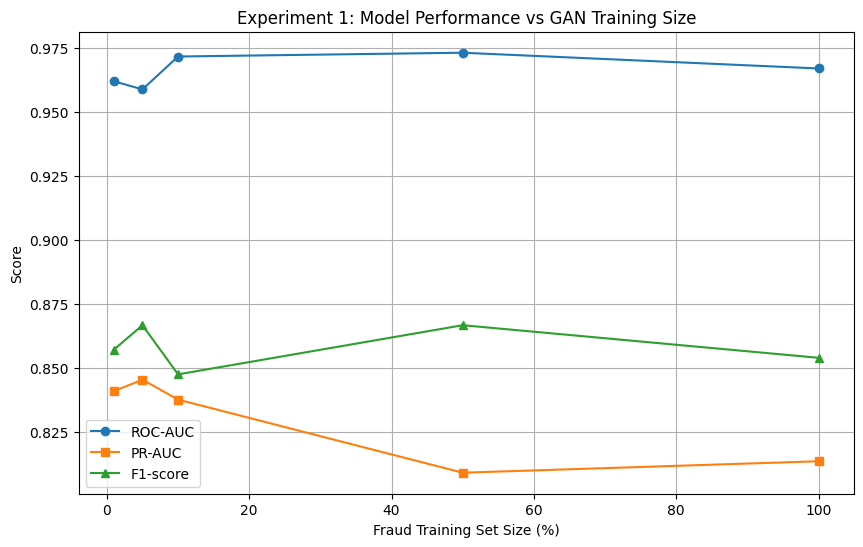

In [ ]:
# Fix the function call to pass the WGAN class
results = experiment_1_scaling_gan_lgbm(WGAN, X_train, y_train, X_test, y_test, scaler)
plot_experiment_1(results)

The WGAN + LGBM setup achieves consistently high ROC-AUC scores (≈0.96–0.97) across all training set sizes, reflecting strong discriminative capability between fraud and non-fraud cases.

Unlike WCGAN, this model delivers much stronger PR-AUC (≈0.80–0.84) and F1-scores (≈0.85–0.87), indicating that it is not only good at ranking instances but also performs well in terms of precision–recall tradeoff and balanced classification. This is particularly important in fraud detection, where recall and precision are critical.

Performance remains stable across training sizes, showing robustness of WGAN-generated samples for boosting LGBM classification. The improvements in both PR-AUC and F1 over WCGAN + LGBM highlight that WGAN produces higher-quality synthetic fraud samples that better reflect real fraud patterns.

Overall, WGAN + LGBM is a reliable and effective augmentation strategy, balancing discrimination (ROC-AUC) with practical detection performance (PR-AUC and F1).

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),https://www.kaggle.com/code/shiratorizawa/wcgan

Note- ChatGPT used for understanding results .